<a href="https://colab.research.google.com/github/GordonWasHere/Electrifying-Tractors-for-Farming-and-Electricity-Grid-Integration/blob/main/TractorOptimisationPassive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files;
uploaded = files.upload()

"""
Upload the following files for the code to run:

Currently Used
 - 'Model RF Tractor Use.xlsx'
 - 'Model TOU Cost ActewAGL 2025.xlsx'
 - 'Model Electricity Profile V1.xlsx'


Link to all model files
https://anu365.sharepoint.com/:f:/r/sites/2025ENGN4300CapstoneProjectRepository/Project%20Documents/06.%20Deliverables%20and%20Models/Models%20and%20Data/FINAL%20DATA%20FOR%20IMPLEMENTATION?csf=1&web=1&e=79O5do
"""

Saving Model Electricity Profile V1.xlsx to Model Electricity Profile V1.xlsx


"\nUpload the following files for the code to run:\n\nCurrently Used\n - 'Model RF Tractor Use.xlsx'\n - 'Model TOU Cost ActewAGL 2025.xlsx'\n - 'Model Electricity Profile V1.xlsx'\n\n\nLink to all model files\nhttps://anu365.sharepoint.com/:f:/r/sites/2025ENGN4300CapstoneProjectRepository/Project%20Documents/06.%20Deliverables%20and%20Models/Models%20and%20Data/FINAL%20DATA%20FOR%20IMPLEMENTATION?csf=1&web=1&e=79O5do\n"

In [6]:


"""
Passive - No Additional Infrastructure Scenario:

Rules:
- The tractor is charged between 10pm to 7am everyday and can be used 7am to 10pm
- The tractor is used as a battery source for residential energy arbitrage.
- The tractor is not used as a battery on days it will be used

Revenue Generation:
- Revenue is generated through residential price arbitrage, storing electricity at low price and using stored energy at high price

Misc Notes:
- Using ActewAGL Energy Plan 2 (Home_Time_Of_Use_Plan_Price_Per_kWh), Column D
- Tractor Battery Capacity is 100kWh, max discharge 14.28 kW, max charging rate 22 kW (Fendt model)
"""

import pandas as pd

# Importing Data ---------------------------------------------------------------

# Tractor Use (Options A -> D)
# Slashing and Undervine Spraying can be done in 1 day or split over 2 days
# 1 day Slashing and Undervine Spraying
excel_tractor_use_A = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load A', usecols = 'I', header=1)
# 1 day Slashing and 2 days Undervine Spraying
excel_tractor_use_B = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load B', usecols = 'I', header=1)
# 2 days Slashing and 1 day Undervine Spraying
excel_tractor_use_C = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load C', usecols = 'I', header=1)
# 2 days Slashing and 2 days Undervine Spraying
excel_tractor_use_D = pd.read_excel("Model RF Tractor Use.xlsx", sheet_name =
                                    'Tractor Load D', usecols = 'I', header=1)
# Note: header=1 is used as document has two header rows


# ActewAGL Residential Electricity Costs
# ActewAGL Plan 1 (Home_Plan_Price_Per_kWh)
excel_R_A1 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='C')
# ActewAGL Energy Plan 2 (Home_Time_Of_Use_Plan_Price_Per_kWh)
excel_R_A2 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='D')
# ActewAGL Plan 3 (Home_Daytime_Economy_Plan_Price_Per_kWh)
excel_R_A3 = pd.read_excel('Model TOU Cost ActewAGL 2025.xlsx', usecols='E')


# Farm Electricity Profile
excel_ele_profile = pd.read_excel('Model Electricity Profile V1.xlsx', sheet_name='Total Profile' ,usecols='I')



Data imported successfully


In [7]:
# Data Processing --------------------------------------------------------------
# Convert to lists

# Using Tractor Use A
# Using  ActewAGL Energy Plan 2

tractor_use = excel_tractor_use_A.iloc[:, 0].tolist()
energy_plan = excel_R_A2.iloc[:, 0].tolist()
ele_profile = excel_ele_profile.iloc[:, 0].tolist()

# Check sum = 8760
if len(tractor_use) != 8760 or len(energy_plan) != 8760 or len(ele_profile) != 8760:
  print(len(tractor_use))
  print(len(energy_plan))
  print(len(ele_profile))
  raise Exception(f"The length of all lists must be 8760 which is the number of hours in a year.")


else:
  print("Data imported successfully")




Data imported successfully


In [11]:
"""

Rules:
1. The tractor is charged between 10pm to 7am everyday and can be used 7am to 10pm
- Mathematically, the tractor is charged on the 0 to 6 and 22 to 23 hours mod 24
- The tractor is used as a battery source for residential energy arbitrage.
- The tractor is not used as a battery on days it will be used

- Tractor Battery Capacity is 100kWh, max discharge 14.28 kW, max charging rate 22 kW (Fendt model)

"""
# Scenario Implementation ------------------------------------------------------

# Scenario Parameters
tractor_charge_rate = 22
tractor_discharge_rate = 14.28
tractor_capacity = 100

# Scenario Variables
battery_status = []
SOC_status = 0
capex = 0
arbitrage_revenue = 0
tractor_used = False

# Main scenario loop
for hour in range(len(tractor_use)):

  # Check if tractor in the next day and if so, set the flag true for 1 day
  if (hour % 24) == 0:

    horizon = min(24, len(tractor_use) - hour) # Ensure bounds arent exceeded
    tractor_used = False

    for i in range(horizon):
      if tractor_use[hour + i] > 0:
        tractor_used = True
        break

  # During off peak hours
  if (hour % 24) <= 6 or (hour % 24) >= 22:

    # Charge the battery based off the diffference betweent he tractor capacity
    charge = min(tractor_capacity - SOC_status, tractor_charge_rate)
    SOC_status += charge
    battery_status.append(SOC_status)

    # Subtract the cost from revenue generation
    arbitrage_revenue = arbitrage_revenue - charge * energy_plan[hour]


  # During main hours, if tractor is used in the day subtract the usage rate
  elif tractor_used:
    SOC_status = SOC_status - tractor_use[hour]
    battery_status.append(SOC_status)

  # During main hours, if tractor is not used, act as a energy source for farm
  else:
    tractor_to_farm = min(tractor_discharge_rate, SOC_status, ele_profile[hour])
    SOC_status = SOC_status - tractor_to_farm
    battery_status.append(SOC_status)
    arbitrage_revenue = arbitrage_revenue + tractor_to_farm * energy_plan[hour]

print(arbitrage_revenue)
print(battery_status)
"""

For each hour of the year:

Add charging rate of 22kWh per hour between hours of 0 to 6 and 22 to 23 mod 24 up to the max capacity DONE
Subtract the cost of electricity for each kWh DONE

if tractor is used in the next day:
  set next 24 hours arbitrage to 0
  subtract the electricity used from capacity
  subtract the cost of electricity from the revenue

else
  use the tractor battery subject to the farm profile up to max discharge rate and capacity
  add the equivalent amount it would have costed to revenue

"""



241.19956673483077
[22, 44, 66, 88, 100, 100, 100, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.

'\n\nFor each hour of the year:\n\nAdd charging rate of 22kWh per hour between hours of 0 to 6 and 22 to 23 mod 24 up to the max capacity DONE\nSubtract the cost of electricity for each kWh DONE\n\nif tractor is used in the next day:\n  set next 24 hours arbitrage to 0\n  subtract the electricity used from capacity\n  subtract the cost of electricity from the revenue\n\nelse\n  use the tractor battery subject to the farm profile up to max discharge rate and capacity\n  add the equivalent amount it would have costed to revenue\n\n'

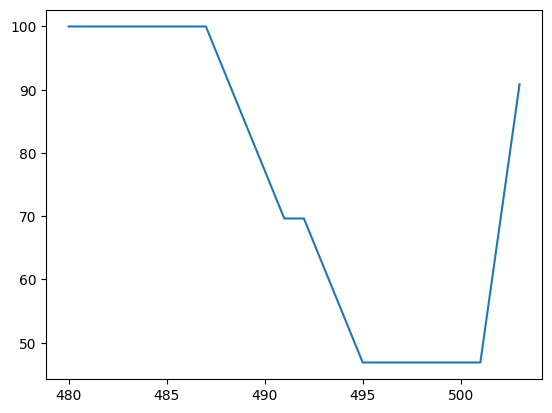

In [17]:
# Visualisation
import matplotlib.pyplot as plt

xs = [x for x in range(len(battery_status))]
plt.plot(xs[480:504], battery_status[480:504])
plt.show()
# Make sure to close the plt object once done
plt.close()